In [27]:
import torch, os, math, pickle, sys, random, time
from tqdm import tqdm
import torch.nn.init as init
import dgl,numpy as np
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, DataLoader as GDataLoader, Batch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter
from collections import Counter
import dgl.function as fn
from dgl.nn.functional import edge_softmax
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import RGCNConv, GraphConv, global_max_pool, GCNConv
from model import DialogueGCN_MELDModel, GraphNetwork_RGCN, GraphNetwork_GAT, \
GraphNetwork_GAT_EdgeFeat, GraphNetwork_GATv2, GraphNetwork_GATv2_EdgeFeat, GraphNetwork_RGAT, \
MatchingAttention, getDataLoaderAndLabels,GCNWithSkipConnections, GCNWithConcatenation
from model import DATASET_PATH
from torch.nn.utils.rnn import pad_sequence
from graph_context_dataset import GraphContextDataset
from sklearn.metrics import classification_report
from model import FCClassifier, MyNetwork, DATASET_PATH, MatchingAttention, RGCNWithGAT, \
RGATWithSkipConnections, EdgeGATWithGCN, EGATConv, EdgeGATWithSkipConnection,Edge2GATWithGCN
EdgeGATWithSkipConnection, EGATConv, EdgeGATWithGCN, \
GCNWithConcatenation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
key=True
WINDOW_SIZE = 3

<b>Make sure to specify which dataset to use
<br>
 - dataset_original
<br>
 - dataset_drop_noise
<br>
 - dataset_smote

In [29]:
# dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"
dataset_path = DATASET_PATH

In [30]:
dataset_path

'dataset_drop_noise'

In [31]:
class GATLayerWithEdgeType(nn.Module):
    def __init__(self, num_in_features_per_head, num_out_features_per_head, num_heads, num_edge_types):
        super(GATLayerWithEdgeType, self).__init__()
        self.num_in_features_per_head = num_in_features_per_head
        self.num_out_features_per_head = num_out_features_per_head
        self.num_heads = num_heads
        self.num_edge_types = num_edge_types

        # Linear projection for node features
        torch.manual_seed(42)
        self.linear_proj = nn.Linear(self.num_in_features_per_head, self.num_heads * self.num_out_features_per_head)
        
        # Edge type embeddings
        torch.manual_seed(42)
        self.edge_type_embedding = nn.Embedding(self.num_edge_types, self.num_heads)
        
    def forward(self, input_data, edge_type):
        node_features, edge_indices = input_data

        # Linear projection for node features
        h_linear = self.linear_proj(node_features.view(-1, self.num_in_features_per_head))
        h_linear = h_linear.view(-1, self.num_heads, self.num_out_features_per_head)
        h_linear = h_linear.permute(0, 2, 1)

        # Edge type embedding
        edge_type_embedding = self.edge_type_embedding(edge_type).transpose(0, 1)

        # Perform matrix multiplication
        attention_scores = torch.matmul(h_linear, edge_type_embedding).squeeze(-1)

        # Softmax to get attention coefficients
        attention_coefficients = F.softmax(attention_scores, dim=-1)

        # Weighted sum of neighbor node representations
        updated_representation = torch.matmul(attention_coefficients.transpose(1, 2), h_linear).mean(dim=2)

        return updated_representation, attention_coefficients
    
class GATWithEdgeType(nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, num_edge_types):
        super(GATWithEdgeType, self).__init__()

        self.gat_net = nn.ModuleList()

        for layer in range(num_of_layers):
            num_in_features = num_heads_per_layer[layer - 1] * num_features_per_layer[layer - 1] if layer > 0 else num_features_per_layer[0]
            num_out_features = num_heads_per_layer[layer] * num_features_per_layer[layer]
            self.gat_net.append(GATLayerWithEdgeType(num_in_features, num_out_features, num_heads_per_layer[layer], num_edge_types))

    def forward(self, node_features, edge_indices, edge_types):
        h = node_features

        attention_scores = []

        for layer in self.gat_net:
            h, attention_coefficients = layer((h, edge_indices), edge_types)
            attention_scores.append(attention_coefficients)

        return h, attention_scores

class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out


In [32]:
def get_ohe(edge_types):
    one_hot_encoding = []
    for edge_type in edge_types:
        if edge_type == 0:
            one_hot_encoding.append([1., 0., 0.])
        elif edge_type == 1:
            one_hot_encoding.append([0., 1., 0.])
        elif edge_type == 2:
            one_hot_encoding.append([0., 0., 1.])
    return torch.tensor(one_hot_encoding)

def get_inferred_edgetypes_GAT(dialog, edge_types):
    inferred_edge_types = []
    inferred_edge_indices = []
    for target_node in dialog.values():
        if len(target_node) == 1:
            inferred_edge_types.append(0)
            inferred_edge_indices.append(0)
        else:
            edge_index = target_node[0][0]
            highest_attention = target_node[0][1]
            for src_node in target_node[1:]:
                if highest_attention < src_node[1]:
                    highest_attention = src_node[1]
                    edge_index = src_node[0]
            inferred_edge_indices.append(edge_index)
            inferred_edge_types.append(edge_types[edge_index].tolist())
    return inferred_edge_indices, inferred_edge_types

def get_inferred_edgetypes_EGAT(edges_target_nodes, sample_edge_types, size_dialog, dialog_id):
    inferred_edge_types = []
    for target_idx in range(size_dialog):
        num_edges = len(edges_target_nodes[target_idx])
        if num_edges == 1:
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            inferred_edge_types.append(edgetype_idx)
        else:
            highest_attn_score = max(edges_target_nodes[target_idx][0][1])
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            for sample_edge in range(1, num_edges):
                cur_highest_attn_score = max(edges_target_nodes[target_idx][sample_edge][1])
                if cur_highest_attn_score > highest_attn_score:
                    highest_attn_score = cur_highest_attn_score
                    edgetype_idx = np.argmax(edges_target_nodes[target_idx][sample_edge][1])
                    edge_idx = edges_target_nodes[target_idx][sample_edge][0]
            inferred_edge_types.append(edgetype_idx)
    return inferred_edge_types

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list


In [33]:
def create_node_pairs_list(start_idx, end_idx):
    list_node_i = []
    list_node_j = []
    end_idx = end_idx - start_idx
    start_idx = 0
    for i in range(start_idx, end_idx+1):
        val = 0
        while (val <= WINDOW_SIZE) and (i+val <= end_idx):
            target_idx = i+val
            if target_idx >= 0:
                list_node_i.append(i)
                list_node_j.append(target_idx)
            val = val+1
    return [list_node_i, list_node_j]

def create_adjacency_dict(node_pairs):
    adjacency_list_dict = {}
    for i in range(0, len(node_pairs[0])):
        source_node, target_node = node_pairs[0][i], node_pairs[1][i]
        if source_node not in adjacency_list_dict:
            adjacency_list_dict[source_node] = [target_node]
        else:
            adjacency_list_dict[source_node].append(target_node)
    return adjacency_list_dict

def get_all_adjacency_list(ranges, key=0):
    all_adjacency_list = []
    for range_pair in ranges:
        start_idx, end_idx = range_pair
        if key == 0:
            output = create_node_pairs_list(start_idx, end_idx)
            output = create_adjacency_dict(output)
        elif key == 1:
            output = create_node_pairs_list(start_idx, end_idx)
            output = torch.tensor(output)
        else:
            print("N/A")
        all_adjacency_list.append(output)
    return all_adjacency_list

def get_all_edge_type_list(edge_indices, encoded_speaker_list):
    dialogs_len = len(edge_indices)
    whole_edge_type_list = []
    for i in range(dialogs_len):
        dialog_nodes_pairs = edge_indices[i]
        dialog_speakers = list(encoded_speaker_list[i])
        dialog_len = len(dialog_nodes_pairs.keys())
        edge_type_list = []
        for j in range(dialog_len):
            src_node = dialog_nodes_pairs[j]
            node_i_idx = j
            win_len = len(src_node)
            for k in range(win_len):
                node_j_idx = src_node[k]
                if node_i_idx == node_j_idx:
                    edge_type_list.append(0)
                else:
                    if dialog_speakers[node_i_idx] != dialog_speakers[node_j_idx]:
                        edge_type_list.append(1)
                    else:
                        edge_type_list.append(2)
        whole_edge_type_list.append(torch.tensor(edge_type_list).to(torch.int64))
    return whole_edge_type_list


In [34]:
def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

<h3> Data Preparation

<h4> Creating graph features from Train, Test and Validation sets

In [35]:
# checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_train.pkl")
# encodedSpeakersTrain = []
# rangesTrain = []

# if not checkFile:
#     print("Run first the contextEncoder1 or 2 to generate this file")
# else:
#     with open('data/dump/' + dataset_path + '/speaker_encoder_train.pkl', "rb") as file:
#         encodedSpeakersTrain, rangesTrain = pickle.load(file)

# checkFile = os.path.isfile("data/dump/" + dataset_path +"/adjListTrain.pkl")
# adjacencyListTrain = []

# if key:
#     adjacencyListTrain = get_all_adjacency_list(rangesTrain)
# else:
#     with open('data/dump/' + dataset_path + '/adjListTrain', "rb") as file:
#         adjacencyListTrain = pickle.load(file)

In [36]:
def getSpeakersAndRanges(file_path):
    checkFile = os.path.isfile(file_path)
    encodedSpeakers = []
#     ranges = []
    if not checkFile:
        print("Run first the contextEncoder1.5 to generate this file")
        return None
    else:
        with open(file_path, "rb") as file:
            encodedSpeakers, ranges = pickle.load(file)
        return encodedSpeakers, ranges
    
def getAdjacencyList(file_path, ranges):
    checkFile = os.path.isfile(file_path)
    adjacencyList = []

    if key:
        adjacencyList = get_all_adjacency_list(ranges)
    else:
        with open(file_path, "rb") as file:
            adjacencyList = pickle.load(file)
    
    return adjacencyList

In [37]:
file_path1 = "data/dump/" + dataset_path + "/speaker_encoder_train.pkl"
file_path2 = "data/dump/" + dataset_path + "/speaker_encoder_test.pkl"
file_path3 = "data/dump/" + dataset_path + "/speaker_encoder_dev.pkl"

encodedSpeakersTrain, rangesTrain = getSpeakersAndRanges(file_path1)
encodedSpeakersTest, rangesTest = getSpeakersAndRanges(file_path2)
encodedSpeakersDev, rangesDev = getSpeakersAndRanges(file_path3)

file_path1 = 'data/dump/' + dataset_path + '/adjListTrain'
file_path2 = 'data/dump/' + dataset_path + '/adjListTest'
file_path3 = 'data/dump/' + dataset_path + '/adjListDev'

adjacencyListTrain = getAdjacencyList(file_path1, rangesTrain)
adjacencyListTest = getAdjacencyList(file_path1, rangesTest)
adjacencyListDev = getAdjacencyList(file_path1, rangesDev)

In [38]:
file_path1 = 'embed/' + dataset_path + '/u_prime_BERT_train.pkl'
file_path2 = 'embed/' + dataset_path + '/u_prime_BERT_test.pkl'
file_path3 = 'embed/' + dataset_path + '/u_prime_BERT_dev.pkl'

# Load the list from the file using pickle
def getFeatures(file_path):
    with open(file_path, 'rb') as file:
        emotions = pickle.load(file)
    return emotions

contextualEmbeddingsTrain = getFeatures(file_path1)
contextualEmbeddingsTest = getFeatures(file_path2)
contextualEmbeddingsDev = getFeatures(file_path3)

In [39]:
# print(contextualEmbeddingsTrain.shape, contextualEmbeddingsTest.shape, contextualEmbeddingsDev.shape)

In [40]:
edgeIndicesTrain = get_all_adjacency_list(rangesTrain)
edgeTypesTrain = get_all_edge_type_list(edgeIndicesTrain, encodedSpeakersTrain)
edgeIndicesTrain = get_all_adjacency_list(rangesTrain, key=1)

edgeIndicesTest = get_all_adjacency_list(rangesTest)
edgeTypesTest = get_all_edge_type_list(edgeIndicesTest, encodedSpeakersTest)
edgeIndicesTest = get_all_adjacency_list(rangesTest, key=1)

edgeIndicesDev = get_all_adjacency_list(rangesDev)
edgeTypesDev = get_all_edge_type_list(edgeIndicesDev, encodedSpeakersDev)
edgeIndicesDev = get_all_adjacency_list(rangesDev, key=1)

In [41]:
len(edgeIndicesDev[0][0])

6

#### Train without relational features

In [42]:
file_path = "data/dump/" + dataset_path + "/labels_train.pkl"
with open(file_path, 'rb') as file:
    y_train = pickle.load(file)
y_train = torch.tensor(y_train)

file_path = "data/dump/" + dataset_path + "/labels_test.pkl"
with open(file_path, 'rb') as file:
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

file_path = "data/dump/" + dataset_path + "/labels_dev.pkl"
with open(file_path, 'rb') as file:
    y_dev = pickle.load(file)
y_dev = torch.tensor(y_dev)

In [43]:
y_tensor_train = [y_train[start:end + 1] for start, end in rangesTrain]
y_tensor_dev = [y_dev[start:end + 1] for start, end in rangesDev]
y_tensor_test = [y_test[start:end + 1] for start, end in rangesTest]

In [44]:
def getDataset(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
    dataset=[]
    for X, edges, Y, edgeTypes in zip(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
        graph_data = Data(
            x=torch.tensor(X, dtype=torch.float),
            edge_index=torch.tensor(edges, dtype=torch.long),
            y=torch.tensor(Y, dtype=torch.long),
            edge_type = torch.tensor(edgeTypes, dtype=torch.long)
        )
        dataset.append(graph_data)
    return dataset

train_dataset = getDataset(contextualEmbeddingsTrain, edgeIndicesTrain, y_tensor_train, edgeTypesTrain)
dev_dataset = getDataset(contextualEmbeddingsDev, edgeIndicesDev, y_tensor_dev, edgeTypesDev)
test_dataset = getDataset(contextualEmbeddingsTest, edgeIndicesTest, y_tensor_test, edgeTypesTest)

train_loader = GDataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = GDataLoader(dev_dataset, batch_size=1, shuffle=True)
test_loader = GDataLoader(test_dataset, batch_size=1, shuffle=True)

C:\Users\edayo\AppData\Local\Temp\ipykernel_17596\3524950887.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(X, dtype=torch.float),
C:\Users\edayo\AppData\Local\Temp\ipykernel_17596\3524950887.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index=torch.tensor(edges, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_17596\3524950887.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(Y, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_17596\3524950887.py:8: UserWarning: 

In [45]:
file_path = 'data/dump/' + dataset_path + '/label_decoder.pkl'
with open(file_path, 'rb') as file:
    label_decoder = pickle.load(file)
    
label_decoder.values()

dict_values(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])

In [46]:
def train_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_model(model_class, train_loader, val_loader, num_features, num_classes):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes)
        model, _, _, _, val_accuracies = train_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

def show_classification_report_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values(), digits=4))

no tuning

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:07<00:00, 208.64it/s]


Epoch 1: Train Loss = 2.0065880860636005, Val Loss = 1.891834188417848, Train Acc = 0.35255212077641984, Val Acc = 0.34857849196538937


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 171.16it/s]


Epoch 2: Train Loss = 2.1031000443232206, Val Loss = 1.9810542354149183, Train Acc = 0.3746944644140906, Val Acc = 0.34610630407911


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 159.11it/s]


Epoch 3: Train Loss = 2.0356777734228735, Val Loss = 2.6070118839737817, Train Acc = 0.37814521926671457, Val Acc = 0.3683559950556242


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 163.64it/s]


Epoch 4: Train Loss = 2.0616837500642062, Val Loss = 1.951019263032622, Train Acc = 0.38274622573687994, Val Acc = 0.33868974042027195


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 171.83it/s]


Epoch 5: Train Loss = 2.0881912192464176, Val Loss = 2.265723191018175, Train Acc = 0.394392523364486, Val Acc = 0.3584672435105068


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 172.48it/s]


Epoch 6: Train Loss = 2.116646689186588, Val Loss = 2.6014740258602087, Train Acc = 0.3834651329978433, Val Acc = 0.3053152039555006
Early stopping triggered


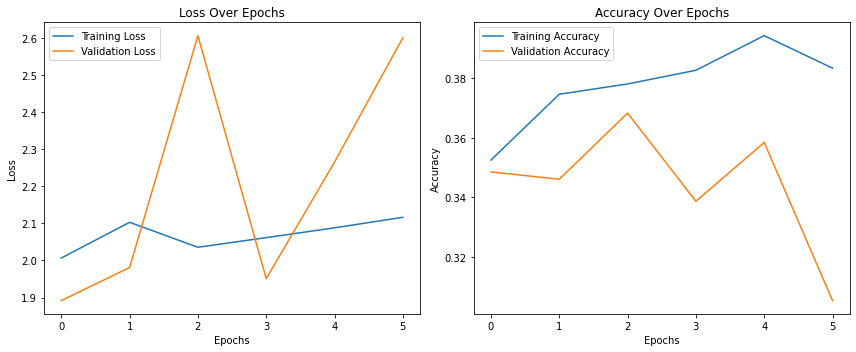

              precision    recall  f1-score   support

       anger     0.0000    0.0000    0.0000       300
     disgust     0.0816    0.0571    0.0672        70
        fear     0.0000    0.0000    0.0000        51
         joy     0.2376    0.4198    0.3034       262
     neutral     0.5552    0.3655    0.4408       881
     sadness     0.1722    0.4415    0.2478       188
    surprise     0.1262    0.2955    0.1769       132

    accuracy                         0.2962      1884
   macro avg     0.1675    0.2256    0.1766      1884
weighted avg     0.3217    0.2962    0.2879      1884



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [47]:
model = GCNWithSkipConnections(num_features=768, num_classes=7)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_model(model, train_loader, val_loader)
show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
show_classification_report_model(model, test_loader)



Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:07<00:00, 221.62it/s]


Epoch 1: Train Loss = 2.090257583791273, Val Loss = 2.253887970752904, Train Acc = 0.37814521926671457, Val Acc = 0.2595797280593325


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 193.64it/s]


Epoch 2: Train Loss = 1.8866537453224637, Val Loss = 2.4652120760949376, Train Acc = 0.41035226455787205, Val Acc = 0.2694684796044499


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 193.06it/s]


Epoch 3: Train Loss = 1.8257402386123394, Val Loss = 3.018445556533748, Train Acc = 0.43048166786484543, Val Acc = 0.19901112484548825


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 183.39it/s]


Epoch 4: Train Loss = 1.8267139588949732, Val Loss = 2.381849868250598, Train Acc = 0.43163191948238677, Val Acc = 0.27812113720642767


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 189.19it/s]


Epoch 5: Train Loss = 1.740808285738785, Val Loss = 2.9405389664869004, Train Acc = 0.4546369518332135, Val Acc = 0.24474660074165636


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 184.69it/s]


Epoch 6: Train Loss = 1.659998548155538, Val Loss = 2.754512005912259, Train Acc = 0.45751258087706687, Val Acc = 0.3646477132262052
Early stopping triggered


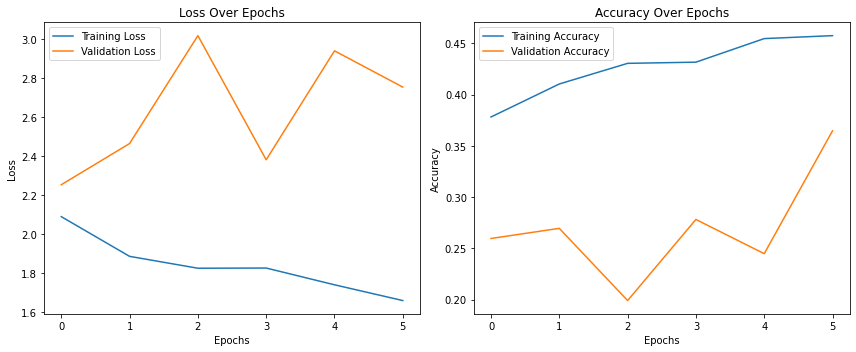

In [48]:
model = GCNWithConcatenation(num_features=768, num_classes=7)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [49]:
show_classification_report_model(model, test_loader)

              precision    recall  f1-score   support

       anger     0.2893    0.1167    0.1663       300
     disgust     1.0000    0.0143    0.0282        70
        fear     0.0000    0.0000    0.0000        51
         joy     0.2104    0.3550    0.2642       262
     neutral     0.5265    0.7662    0.6241       881
     sadness     0.0000    0.0000    0.0000       188
    surprise     0.2941    0.0758    0.1205       132

    accuracy                         0.4321      1884
   macro avg     0.3315    0.1897    0.1719      1884
weighted avg     0.3793    0.4321    0.3646      1884



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

with tuning

In [50]:
best_model, best_params = tune_model(GCNWithSkipConnections, train_loader, val_loader, 768, 7)

Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:07<00:00, 203.46it/s]


Epoch 1: Train Loss = 1.5542181039261878, Val Loss = 1.6053595137713579, Train Acc = 0.4484543493889288, Val Acc = 0.38936959208899874


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 185.51it/s]


Epoch 2: Train Loss = 1.4448646769790865, Val Loss = 1.6914384224144696, Train Acc = 0.47074047447879225, Val Acc = 0.3992583436341162


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 180.15it/s]


Epoch 3: Train Loss = 1.3979522277101386, Val Loss = 1.651071435492027, Train Acc = 0.47951114306254494, Val Acc = 0.3992583436341162


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:10<00:00, 154.67it/s]


Epoch 4: Train Loss = 1.3478382099279078, Val Loss = 1.5729118507777529, Train Acc = 0.49245147375988496, Val Acc = 0.3980222496909765


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 167.74it/s]


Epoch 5: Train Loss = 1.3123519331291882, Val Loss = 1.6076667637660587, Train Acc = 0.504960460100647, Val Acc = 0.4054388133498146


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 174.49it/s]


Epoch 6: Train Loss = 1.2773391995320955, Val Loss = 1.6754116087858313, Train Acc = 0.507979870596693, Val Acc = 0.41409147095179233


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 172.45it/s]


Epoch 7: Train Loss = 1.2429303172562314, Val Loss = 1.7034759508271522, Train Acc = 0.5194823867721065, Val Acc = 0.4079110012360939


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 167.56it/s]


Epoch 8: Train Loss = 1.2167334519678572, Val Loss = 1.7358569903620358, Train Acc = 0.5243709561466571, Val Acc = 0.3967861557478368


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 165.38it/s]


Epoch 9: Train Loss = 1.1828484183062402, Val Loss = 1.8101809148130745, Train Acc = 0.5314162473040978, Val Acc = 0.38442521631644005


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:12<00:00, 130.84it/s]


Epoch 10: Train Loss = 1.1546566377192153, Val Loss = 1.7754809649413443, Train Acc = 0.5443565780014378, Val Acc = 0.38442521631644005


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 176.95it/s]


Epoch 11: Train Loss = 1.1307670487330228, Val Loss = 1.8516761513766398, Train Acc = 0.5470884255930984, Val Acc = 0.35970333745364647


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 176.13it/s]


Epoch 12: Train Loss = 1.1139027401576198, Val Loss = 1.793138051634939, Train Acc = 0.5575844716031632, Val Acc = 0.35970333745364647


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 173.54it/s]


Epoch 13: Train Loss = 1.0859199532105936, Val Loss = 1.829249827585784, Train Acc = 0.5614665708123652, Val Acc = 0.38813349814585907


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 179.53it/s]


Epoch 14: Train Loss = 1.070326461019499, Val Loss = 1.894877621399358, Train Acc = 0.5685118619698059, Val Acc = 0.3547589616810878
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:07<00:00, 212.01it/s]


Epoch 1: Train Loss = 1.5524400508955534, Val Loss = 1.5703769644786572, Train Acc = 0.45391804457225016, Val Acc = 0.40296662546353523


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 188.99it/s]


Epoch 2: Train Loss = 1.4521064127065824, Val Loss = 1.583767504234032, Train Acc = 0.46930265995686554, Val Acc = 0.4042027194066749


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 179.66it/s]


Epoch 3: Train Loss = 1.4072578614694946, Val Loss = 1.6131436760202418, Train Acc = 0.47994248741912293, Val Acc = 0.4177997527812114


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 177.15it/s]


Epoch 4: Train Loss = 1.3571545129139868, Val Loss = 1.5913098430985888, Train Acc = 0.49086987778576563, Val Acc = 0.40667490729295425


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 168.49it/s]


Epoch 5: Train Loss = 1.3058981848528763, Val Loss = 1.692412834302545, Train Acc = 0.4996405463695183, Val Acc = 0.38813349814585907


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 177.65it/s]


Epoch 6: Train Loss = 1.2725657114350901, Val Loss = 1.6193329865122077, Train Acc = 0.504097771387491, Val Acc = 0.4177997527812114


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 177.47it/s]


Epoch 7: Train Loss = 1.2338164639495013, Val Loss = 1.721480885309539, Train Acc = 0.5176132278936018, Val Acc = 0.40173053152039556


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:10<00:00, 155.39it/s]


Epoch 8: Train Loss = 1.1973916063623582, Val Loss = 1.741573558945961, Train Acc = 0.5314162473040978, Val Acc = 0.3226205191594561


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 161.11it/s]


Epoch 9: Train Loss = 1.170072644363364, Val Loss = 1.717988255869579, Train Acc = 0.5388928828181164, Val Acc = 0.3868974042027194


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 161.58it/s]


Epoch 10: Train Loss = 1.1385306345439055, Val Loss = 1.839728291398786, Train Acc = 0.5397555715312725, Val Acc = 0.37330037082818296


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 163.55it/s]


Epoch 11: Train Loss = 1.1155670437545255, Val Loss = 1.8514647491166156, Train Acc = 0.5577282530553559, Val Acc = 0.38442521631644005
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 190.44it/s]


Epoch 1: Train Loss = 91.06485975682234, Val Loss = 110.55372616683542, Train Acc = 0.29130122214234366, Val Acc = 0.2546353522867738


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 170.14it/s]


Epoch 2: Train Loss = 119.64923369579836, Val Loss = 139.0334576966655, Train Acc = 0.30093457943925234, Val Acc = 0.21755253399258342


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 160.64it/s]


Epoch 3: Train Loss = 126.6103402011449, Val Loss = 117.92113446428445, Train Acc = 0.29834651329978434, Val Acc = 0.3646477132262052


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:10<00:00, 146.12it/s]


Epoch 4: Train Loss = 129.0591489151245, Val Loss = 187.77676448876525, Train Acc = 0.31315600287562906, Val Acc = 0.1681087762669963


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:10<00:00, 158.30it/s]


Epoch 5: Train Loss = 133.9932035309765, Val Loss = 303.50529038377584, Train Acc = 0.31387491013659236, Val Acc = 0.1681087762669963


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:11<00:00, 141.05it/s]


Epoch 6: Train Loss = 135.9883422445478, Val Loss = 156.69606757176905, Train Acc = 0.32063263838964773, Val Acc = 0.27812113720642767


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:10<00:00, 154.57it/s]


Epoch 7: Train Loss = 131.4507185952337, Val Loss = 163.12850505245322, Train Acc = 0.3342918763479511, Val Acc = 0.39555006180469715


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 168.71it/s]


Epoch 8: Train Loss = 138.17941627862749, Val Loss = 116.03268837375484, Train Acc = 0.35197699496764917, Val Acc = 0.35599505562422745


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 170.36it/s]


Epoch 9: Train Loss = 135.6743496724812, Val Loss = 123.26279512297025, Train Acc = 0.33314162473040976, Val Acc = 0.31396786155747836


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 168.00it/s]


Epoch 10: Train Loss = 143.33874698004394, Val Loss = 144.2169008729967, Train Acc = 0.34579439252336447, Val Acc = 0.23856613102595797


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 168.82it/s]


Epoch 11: Train Loss = 146.5930604344184, Val Loss = 172.8382716735974, Train Acc = 0.3383177570093458, Val Acc = 0.3238566131025958
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 186.73it/s]


Epoch 1: Train Loss = 89.71268086106836, Val Loss = 120.04967628322711, Train Acc = 0.2862688713156003, Val Acc = 0.2249690976514215


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 165.25it/s]


Epoch 2: Train Loss = 112.55679629408992, Val Loss = 140.2601031153073, Train Acc = 0.30711718188353704, Val Acc = 0.242274412855377


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 169.10it/s]


Epoch 3: Train Loss = 122.9348347723863, Val Loss = 240.66770790275095, Train Acc = 0.3059669302659957, Val Acc = 0.39060568603213847


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 171.06it/s]


Epoch 4: Train Loss = 133.33405020207454, Val Loss = 234.7765278372741, Train Acc = 0.3115744069015097, Val Acc = 0.2088998763906057


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 169.90it/s]


Epoch 5: Train Loss = 136.08937266221076, Val Loss = 120.72900829037226, Train Acc = 0.32365204888569377, Val Acc = 0.19283065512978986


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 170.47it/s]


Epoch 6: Train Loss = 130.24810814857582, Val Loss = 189.3766569114399, Train Acc = 0.33055355859094177, Val Acc = 0.17181705809641531
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 189.99it/s]


Epoch 1: Train Loss = 87.57634474947541, Val Loss = 64.7606613047056, Train Acc = 0.2713156002875629, Val Acc = 0.33868974042027195


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 165.71it/s]


Epoch 2: Train Loss = 129.5575890127095, Val Loss = 132.84516092504597, Train Acc = 0.2936017253774263, Val Acc = 0.27812113720642767


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 170.34it/s]


Epoch 3: Train Loss = 119.66068654298186, Val Loss = 97.76999112942357, Train Acc = 0.312293314162473, Val Acc = 0.3374536464771323


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 171.03it/s]


Epoch 4: Train Loss = 130.84439961939157, Val Loss = 123.58447532374592, Train Acc = 0.31171818835370235, Val Acc = 0.242274412855377


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 168.05it/s]


Epoch 5: Train Loss = 140.19323035629148, Val Loss = 104.2992019048233, Train Acc = 0.3160316319194824, Val Acc = 0.25339925834363414


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 171.06it/s]


Epoch 6: Train Loss = 123.87363696900638, Val Loss = 74.65419160633816, Train Acc = 0.3246585190510424, Val Acc = 0.28059332509270707


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:11<00:00, 134.58it/s]


Epoch 7: Train Loss = 140.06416331007668, Val Loss = 103.72874034249587, Train Acc = 0.3294033069734004, Val Acc = 0.2669962917181706


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 160.57it/s]


Epoch 8: Train Loss = 135.65733365806895, Val Loss = 150.7412553875899, Train Acc = 0.3321351545650611, Val Acc = 0.29913473423980225


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 168.33it/s]


Epoch 9: Train Loss = 149.63716037746642, Val Loss = 105.82383763144477, Train Acc = 0.34378145219266715, Val Acc = 0.31396786155747836


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 169.92it/s]


Epoch 10: Train Loss = 138.7710863638427, Val Loss = 122.39908436953728, Train Acc = 0.3462257368799425, Val Acc = 0.2657601977750309


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:10<00:00, 157.93it/s]


Epoch 11: Train Loss = 142.15073435084815, Val Loss = 218.7997138285872, Train Acc = 0.35240833932422716, Val Acc = 0.19283065512978986
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.4177997527812114


In [51]:
show_classification_report_model(best_model, test_loader)

              precision    recall  f1-score   support

       anger     0.3438    0.0367    0.0663       300
     disgust     0.1176    0.0571    0.0769        70
        fear     0.0400    0.0392    0.0396        51
         joy     0.2930    0.2863    0.2896       262
     neutral     0.5211    0.7696    0.6214       881
     sadness     0.2895    0.1170    0.1667       188
    surprise     0.2074    0.2121    0.2097       132

    accuracy                         0.4352      1884
   macro avg     0.2589    0.2169    0.2100      1884
weighted avg     0.3880    0.4352    0.3767      1884



In [52]:
best_model, best_params = tune_model(GCNWithConcatenation, train_loader, val_loader, 768, 7)

show_classification_report_model(best_model, test_loader)

Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:07<00:00, 220.17it/s]


Epoch 1: Train Loss = 15.936342876593484, Val Loss = 15.601764598456617, Train Acc = 0.3210639827462257, Val Acc = 0.3695920889987639


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 185.96it/s]


Epoch 2: Train Loss = 13.058320390768525, Val Loss = 21.31730564908019, Train Acc = 0.3641984184040259, Val Acc = 0.19283065512978986


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 184.76it/s]


Epoch 3: Train Loss = 12.866728492221384, Val Loss = 16.198995193147915, Train Acc = 0.37526959022286127, Val Acc = 0.3572311495673671


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 182.53it/s]


Epoch 4: Train Loss = 12.737117065352882, Val Loss = 23.866664319483245, Train Acc = 0.396117900790798, Val Acc = 0.23856613102595797


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 185.27it/s]


Epoch 5: Train Loss = 12.82907683906886, Val Loss = 16.845685524407756, Train Acc = 0.409058231488138, Val Acc = 0.3003708281829419


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 184.92it/s]


Epoch 6: Train Loss = 12.355726923883605, Val Loss = 18.06154603633341, Train Acc = 0.4035945363048167, Val Acc = 0.32756489493201485


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 182.76it/s]


Epoch 7: Train Loss = 12.05356592711543, Val Loss = 20.26928826823748, Train Acc = 0.41897915168943206, Val Acc = 0.2719406674907293


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 182.56it/s]


Epoch 8: Train Loss = 12.743404803009343, Val Loss = 18.26586270368461, Train Acc = 0.4214234363767074, Val Acc = 0.26823238566131025


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 190.23it/s]


Epoch 9: Train Loss = 11.37523596114828, Val Loss = 20.87572521747926, Train Acc = 0.4389647735442128, Val Acc = 0.2669962917181706


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 178.03it/s]


Epoch 10: Train Loss = 12.480318102572179, Val Loss = 25.750340228306168, Train Acc = 0.4375269590222861, Val Acc = 0.2138442521631644


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 173.27it/s]


Epoch 11: Train Loss = 12.334643213189185, Val Loss = 21.30575715667685, Train Acc = 0.43608914450035946, Val Acc = 0.32014833127317677
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:07<00:00, 219.23it/s]


Epoch 1: Train Loss = 1.540697616841691, Val Loss = 1.5791957733666369, Train Acc = 0.4552120776419842, Val Acc = 0.3856613102595797


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 168.03it/s]


Epoch 2: Train Loss = 1.4353819341781158, Val Loss = 1.5574683916979823, Train Acc = 0.4749101365923796, Val Acc = 0.40914709517923364


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 186.55it/s]


Epoch 3: Train Loss = 1.3843111745656587, Val Loss = 1.6648131434259743, Train Acc = 0.48296189791516897, Val Acc = 0.39555006180469715


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 182.49it/s]


Epoch 4: Train Loss = 1.3493992813231812, Val Loss = 1.5681151571532188, Train Acc = 0.4891445003594536, Val Acc = 0.3967861557478368


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 189.03it/s]


Epoch 5: Train Loss = 1.3220669023167126, Val Loss = 1.613635646298601, Train Acc = 0.497627606038821, Val Acc = 0.38936959208899874


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 191.13it/s]


Epoch 6: Train Loss = 1.292270476678832, Val Loss = 1.6677200766326172, Train Acc = 0.507979870596693, Val Acc = 0.39060568603213847


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 188.67it/s]


Epoch 7: Train Loss = 1.27225778633799, Val Loss = 1.6119151112481291, Train Acc = 0.5114306254493171, Val Acc = 0.40296662546353523


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 188.57it/s]


Epoch 8: Train Loss = 1.2550595731847458, Val Loss = 1.6423369570465511, Train Acc = 0.5158878504672897, Val Acc = 0.3930778739184178


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 175.67it/s]


Epoch 9: Train Loss = 1.2383778123947455, Val Loss = 1.6677736736870752, Train Acc = 0.5236520488856937, Val Acc = 0.4004944375772559


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 175.45it/s]


Epoch 10: Train Loss = 1.222904265079394, Val Loss = 1.6640504262423867, Train Acc = 0.525233644859813, Val Acc = 0.38936959208899874


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 163.16it/s]


Epoch 11: Train Loss = 1.2063936336201755, Val Loss = 1.7038679533257273, Train Acc = 0.5227893601725377, Val Acc = 0.3967861557478368


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:10<00:00, 158.22it/s]


Epoch 12: Train Loss = 1.1918642022209855, Val Loss = 1.680926862021385, Train Acc = 0.5360172537742631, Val Acc = 0.3720642768850433
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:07<00:00, 211.16it/s]


Epoch 1: Train Loss = 1.535317554675812, Val Loss = 1.6155380057583888, Train Acc = 0.45564342199856217, Val Acc = 0.3943139678615575


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 177.97it/s]


Epoch 2: Train Loss = 1.4314726486952238, Val Loss = 1.5826349038208647, Train Acc = 0.47332854061826024, Val Acc = 0.38936959208899874


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 168.99it/s]


Epoch 3: Train Loss = 1.3838241613782023, Val Loss = 1.5722816991688582, Train Acc = 0.48554996405463696, Val Acc = 0.4042027194066749


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 170.45it/s]


Epoch 4: Train Loss = 1.3419341302619923, Val Loss = 1.560863805521885, Train Acc = 0.49388928828181167, Val Acc = 0.40296662546353523


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 167.05it/s]


Epoch 5: Train Loss = 1.3194844342336547, Val Loss = 1.6057859265745567, Train Acc = 0.5022286125089863, Val Acc = 0.38813349814585907


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 173.06it/s]


Epoch 6: Train Loss = 1.293194087517802, Val Loss = 1.604269217094177, Train Acc = 0.504529115744069, Val Acc = 0.40667490729295425


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 176.47it/s]


Epoch 7: Train Loss = 1.2785742535239428, Val Loss = 1.6770103236137353, Train Acc = 0.509705248023005, Val Acc = 0.3572311495673671


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 179.22it/s]


Epoch 8: Train Loss = 1.2586492402924774, Val Loss = 1.638761030482541, Train Acc = 0.5177570093457944, Val Acc = 0.39555006180469715


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 185.16it/s]


Epoch 9: Train Loss = 1.241889885206817, Val Loss = 1.7263965040004898, Train Acc = 0.5183321351545651, Val Acc = 0.3584672435105068
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:07<00:00, 203.18it/s]


Epoch 1: Train Loss = 1.542494106746891, Val Loss = 1.5745905702337255, Train Acc = 0.4526240115025162, Val Acc = 0.40667490729295425


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 178.20it/s]


Epoch 2: Train Loss = 1.4331305507448517, Val Loss = 1.5815240036090608, Train Acc = 0.4716031631919482, Val Acc = 0.3992583436341162


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 189.21it/s]


Epoch 3: Train Loss = 1.3849605844832338, Val Loss = 1.59473307614256, Train Acc = 0.485118619698059, Val Acc = 0.3992583436341162


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 176.40it/s]


Epoch 4: Train Loss = 1.344806369656805, Val Loss = 1.6033050914116094, Train Acc = 0.49245147375988496, Val Acc = 0.4054388133498146


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 182.81it/s]


Epoch 5: Train Loss = 1.319198787916142, Val Loss = 1.6103836590139737, Train Acc = 0.495039539899353, Val Acc = 0.3967861557478368


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 195.28it/s]


Epoch 6: Train Loss = 1.2878805348410338, Val Loss = 1.7270852930733722, Train Acc = 0.5076923076923077, Val Acc = 0.3621755253399258


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 175.78it/s]


Epoch 7: Train Loss = 1.2604913222849818, Val Loss = 1.6852620960456397, Train Acc = 0.5114306254493171, Val Acc = 0.40667490729295425


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:10<00:00, 150.63it/s]


Epoch 8: Train Loss = 1.2456572745980634, Val Loss = 1.679016998689163, Train Acc = 0.517469446441409, Val Acc = 0.39060568603213847


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 173.46it/s]


Epoch 9: Train Loss = 1.2225602847531025, Val Loss = 1.6500488628307586, Train Acc = 0.525664989216391, Val Acc = 0.40296662546353523


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 183.21it/s]


Epoch 10: Train Loss = 1.200037856217971, Val Loss = 1.664034922428319, Train Acc = 0.5327102803738317, Val Acc = 0.3819530284301607


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 194.79it/s]


Epoch 11: Train Loss = 1.1833703431807534, Val Loss = 1.690173759689472, Train Acc = 0.5367361610352265, Val Acc = 0.380716934487021
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:07<00:00, 210.39it/s]


Epoch 1: Train Loss = 14.711302697275658, Val Loss = 16.409203099694764, Train Acc = 0.3260963335729691, Val Acc = 0.24474660074165636


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 187.03it/s]


Epoch 2: Train Loss = 13.159197302414746, Val Loss = 13.681857097260837, Train Acc = 0.35643421998562186, Val Acc = 0.30778739184178


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 175.49it/s]


Epoch 3: Train Loss = 13.104386047591357, Val Loss = 16.011829699421074, Train Acc = 0.3886412652767793, Val Acc = 0.3399258343634116


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:09<00:00, 172.64it/s]


Epoch 4: Train Loss = 12.958466809296539, Val Loss = 20.02576511143592, Train Acc = 0.40186915887850466, Val Acc = 0.24351050679851668


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 179.65it/s]


Epoch 5: Train Loss = 12.731699781912521, Val Loss = 20.677482706660776, Train Acc = 0.4048885693745507, Val Acc = 0.3572311495673671


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 176.85it/s]


Epoch 6: Train Loss = 12.510173164086623, Val Loss = 25.206198881653886, Train Acc = 0.41020848310567937, Val Acc = 0.3374536464771323


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 186.82it/s]


Epoch 7: Train Loss = 11.666574371206496, Val Loss = 17.66561580823506, Train Acc = 0.4201294033069734, Val Acc = 0.32138442521631644


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 189.12it/s]


Epoch 8: Train Loss = 12.342762692814452, Val Loss = 19.2427314136481, Train Acc = 0.4228612508986341, Val Acc = 0.3547589616810878


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 181.67it/s]


Epoch 9: Train Loss = 12.518939199773131, Val Loss = 24.894907008875965, Train Acc = 0.42573687994248743, Val Acc = 0.38442521631644005


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 183.26it/s]


Epoch 10: Train Loss = 11.833438126090952, Val Loss = 19.648922427200876, Train Acc = 0.43867721063982745, Val Acc = 0.34981458590852904


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 189.79it/s]


Epoch 11: Train Loss = 12.039293022536073, Val Loss = 21.66130307807075, Train Acc = 0.44974838245866283, Val Acc = 0.3399258343634116


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:08<00:00, 188.85it/s]


Epoch 12: Train Loss = 12.012069194271971, Val Loss = 22.326105671704624, Train Acc = 0.44514737598849746, Val Acc = 0.23856613102595797
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.40914709517923364
              precision    recall  f1-score   support

       anger     0.2316    0.2833    0.2549       300
     disgust     0.5000    0.0143    0.0278        70
        fear     0.1538    0.0392    0.0625        51
         joy     0.2540    0.4198    0.3165       262
     neutral     0.5632    0.6322    0.5957       881
     sadness     0.2414    0.0372    0.0645       188
    surprise     0.2941    0.1136    0.1639       132

    accuracy                         0.4124      1884
   macro avg     0.3197    0.2200    0.2123      1884
weighted avg     0.4030    0.4124    0.3838      1884



In [53]:
# model = GCNWithSkipConnections(num_features=768, num_classes=7)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []
# early_stop_threshold = 0.0001
# best_val_loss = float('inf')
# no_improve_epochs = 0
# max_no_improve_epochs = 5

# for epoch in range(25):
#     model.train()
#     train_loss = 0
#     correct_train = 0
#     total_train = 0
    
#     for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#         optimizer.zero_grad()
#         out = model(data.x, data.edge_index)
#         loss = criterion(out, data.y)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
        
#         preds = out.argmax(dim=1)
#         correct_train += (preds == data.y).sum().item()
#         total_train += data.y.size(0)
    
#     train_losses.append(train_loss / len(train_loader))
#     train_accuracies.append(correct_train / total_train)
    
#     model.eval()
#     val_loss = 0
#     correct_val = 0
#     total_val = 0
    
#     with torch.no_grad():
#         for data in val_loader:
#             out = model(data.x, data.edge_index)
#             loss = criterion(out, data.y)
#             val_loss += loss.item()
            
#             preds = out.argmax(dim=1)
#             correct_val += (preds == data.y).sum().item()
#             total_val += data.y.size(0)
    
#     val_losses.append(val_loss / len(val_loader))
#     val_accuracies.append(correct_val / total_val)
    
#     print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")
    
#     if best_val_loss - val_losses[-1] < early_stop_threshold:
#         no_improve_epochs += 1
#         if no_improve_epochs >= max_no_improve_epochs:
#             print("Early stopping triggered")
#             break
#     else:
#         no_improve_epochs = 0
#         best_val_loss = val_losses[-1]

In [54]:
# # Plot learning curves
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss Over Epochs')

# plt.subplot(1, 2, 2)
# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Accuracy Over Epochs')

# plt.tight_layout()
# plt.show()

In [55]:
# # Classification report on test set
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for data in test_loader:
#         out = model(data.x, data.edge_index)
#         preds = out.argmax(dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(data.y.cpu().numpy())

# print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

#### RGCN

In [56]:
def train_relational_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index , data.edge_type)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.edge_type)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_relation_model(model_class, train_loader, val_loader, num_features, num_classes, num_relations):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes, num_relations)
        model, _, _, _, val_accuracies = train_relational_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_classification_report_relation_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index, data.edge_type)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values(),digits = 4))

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:14<00:00, 112.18it/s]


Epoch 1: Train Loss = 2.0325022470056653, Val Loss = 2.088804834655353, Train Acc = 0.35384615384615387, Val Acc = 0.3757725587144623


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 95.95it/s]


Epoch 2: Train Loss = 2.1389631549077066, Val Loss = 2.9815603727337177, Train Acc = 0.3532710280373832, Val Acc = 0.3411619283065513


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 94.96it/s]


Epoch 3: Train Loss = 2.0879501959379945, Val Loss = 2.213248381473748, Train Acc = 0.3798705966930266, Val Acc = 0.273176761433869


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 92.34it/s]


Epoch 4: Train Loss = 2.061978390902487, Val Loss = 2.5770230376955325, Train Acc = 0.39324227174694465, Val Acc = 0.311495673671199


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 95.85it/s]


Epoch 5: Train Loss = 2.041357088340235, Val Loss = 2.169592742996263, Train Acc = 0.3938173975557153, Val Acc = 0.37453646477132263


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 89.53it/s]


Epoch 6: Train Loss = 2.084448362491856, Val Loss = 2.254103750797915, Train Acc = 0.4005751258087707, Val Acc = 0.3646477132262052
Early stopping triggered


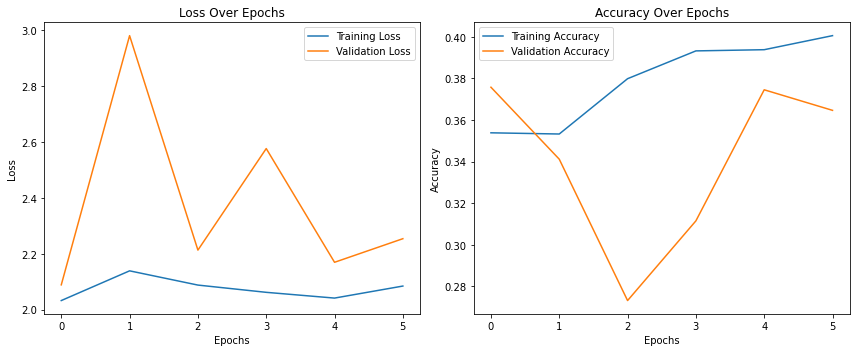

              precision    recall  f1-score   support

       anger     0.3103    0.0600    0.1006       300
     disgust     0.1333    0.0286    0.0471        70
        fear     0.0000    0.0000    0.0000        51
         joy     0.2167    0.2481    0.2313       262
     neutral     0.5216    0.8207    0.6378       881
     sadness     0.3684    0.1489    0.2121       188
    surprise     0.2500    0.0076    0.0147       132

    accuracy                         0.4443      1884
   macro avg     0.2572    0.1877    0.1777      1884
weighted avg     0.3827    0.4443    0.3704      1884



In [57]:
model = RGCNWithGAT(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

In [58]:
best_model, best_params = tune_relation_model(RGCNWithGAT, train_loader, val_loader, 768, 7, 3)

show_classification_report_relation_model(best_model, test_loader)

Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:13<00:00, 117.14it/s]


Epoch 1: Train Loss = 1.5543881483394792, Val Loss = 1.5798066747306017, Train Acc = 0.44730409777138747, Val Acc = 0.3980222496909765


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 102.64it/s]


Epoch 2: Train Loss = 1.4514194533547917, Val Loss = 1.6827844442992375, Train Acc = 0.4680086268871316, Val Acc = 0.40173053152039556


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 99.79it/s]


Epoch 3: Train Loss = 1.4040419629186167, Val Loss = 1.5767073302433408, Train Acc = 0.48368080517613227, Val Acc = 0.40667490729295425


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.75it/s]


Epoch 4: Train Loss = 1.3669721614804016, Val Loss = 1.5888307764025158, Train Acc = 0.4806613946800863, Val Acc = 0.39184177997527814


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 102.86it/s]


Epoch 5: Train Loss = 1.3192969296662422, Val Loss = 1.669542173153074, Train Acc = 0.49949676491732564, Val Acc = 0.39555006180469715


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 103.24it/s]


Epoch 6: Train Loss = 1.2805888292260037, Val Loss = 1.681388916934065, Train Acc = 0.504097771387491, Val Acc = 0.3572311495673671


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 103.22it/s]


Epoch 7: Train Loss = 1.24902205332241, Val Loss = 1.6929378949949894, Train Acc = 0.5114306254493171, Val Acc = 0.40296662546353523


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 102.97it/s]


Epoch 8: Train Loss = 1.2067932653837892, Val Loss = 1.7259426397349447, Train Acc = 0.5189072609633357, Val Acc = 0.377008652657602


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 103.30it/s]


Epoch 9: Train Loss = 1.1784617065414504, Val Loss = 1.7302169202290145, Train Acc = 0.5286843997124371, Val Acc = 0.377008652657602


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 103.22it/s]


Epoch 10: Train Loss = 1.15783729164504, Val Loss = 1.8059131952342142, Train Acc = 0.5404744787922358, Val Acc = 0.3868974042027194


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 103.43it/s]


Epoch 11: Train Loss = 1.1266201128499929, Val Loss = 1.8200514570539221, Train Acc = 0.5426312005751258, Val Acc = 0.3646477132262052


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 102.15it/s]


Epoch 12: Train Loss = 1.1018323561945527, Val Loss = 1.8172207276515773, Train Acc = 0.5587347232207045, Val Acc = 0.3695920889987639


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.64it/s]


Epoch 13: Train Loss = 1.0809029759038637, Val Loss = 1.9035308245073985, Train Acc = 0.5621854780733285, Val Acc = 0.3819530284301607
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:14<00:00, 112.34it/s]


Epoch 1: Train Loss = 85.59692883505376, Val Loss = 237.37825972792749, Train Acc = 0.28080517613227896, Val Acc = 0.22991347342398022


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 91.16it/s]


Epoch 2: Train Loss = 122.76456865451604, Val Loss = 114.12031533212604, Train Acc = 0.28569374550682963, Val Acc = 0.276885043263288


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 92.64it/s]


Epoch 3: Train Loss = 131.01905577143785, Val Loss = 143.58346983834215, Train Acc = 0.30524802300503234, Val Acc = 0.3238566131025958


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:18<00:00, 87.68it/s]


Epoch 4: Train Loss = 124.94499992598463, Val Loss = 131.50075286393735, Train Acc = 0.302372393961179, Val Acc = 0.3263288009888752


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 91.84it/s]


Epoch 5: Train Loss = 125.81998063197776, Val Loss = 210.68536863617658, Train Acc = 0.31143062544931704, Val Acc = 0.39060568603213847


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 91.11it/s]


Epoch 6: Train Loss = 141.5587974529928, Val Loss = 87.4196032514679, Train Acc = 0.3194823867721064, Val Acc = 0.29666254635352285


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 90.82it/s]


Epoch 7: Train Loss = 133.39440022521603, Val Loss = 110.7457414976455, Train Acc = 0.3334291876347951, Val Acc = 0.3226205191594561


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 92.93it/s]


Epoch 8: Train Loss = 142.43870391957958, Val Loss = 131.12057491332484, Train Acc = 0.33055355859094177, Val Acc = 0.22373300370828184


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 93.48it/s]


Epoch 9: Train Loss = 144.0644216107345, Val Loss = 175.79610523369257, Train Acc = 0.3386053199137311, Val Acc = 0.29913473423980225


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 90.78it/s]


Epoch 10: Train Loss = 145.38019372921767, Val Loss = 114.11453936105879, Train Acc = 0.33544212796549244, Val Acc = 0.2941903584672435


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 92.84it/s]


Epoch 11: Train Loss = 144.91170624716582, Val Loss = 140.49873533905773, Train Acc = 0.3491013659237958, Val Acc = 0.33868974042027195


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 90.90it/s]


Epoch 12: Train Loss = 143.03753369755813, Val Loss = 232.1484846876395, Train Acc = 0.34982027318475917, Val Acc = 0.3695920889987639


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 89.35it/s]


Epoch 13: Train Loss = 145.79220039155956, Val Loss = 129.2168792176423, Train Acc = 0.35255212077641984, Val Acc = 0.26823238566131025


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 90.51it/s]


Epoch 14: Train Loss = 139.29345233075932, Val Loss = 178.706919515073, Train Acc = 0.36290438533429187, Val Acc = 0.24474660074165636


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 92.32it/s]


Epoch 15: Train Loss = 147.42490685947, Val Loss = 141.53494229571305, Train Acc = 0.3606038820992092, Val Acc = 0.27070457354758964


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 92.85it/s]


Epoch 16: Train Loss = 141.23779407699382, Val Loss = 149.27359145560436, Train Acc = 0.3664989216391086, Val Acc = 0.27441285537700866
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:14<00:00, 111.18it/s]


Epoch 1: Train Loss = 2.080874873058969, Val Loss = 2.3361975671035315, Train Acc = 0.3532710280373832, Val Acc = 0.2694684796044499


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.40it/s]


Epoch 2: Train Loss = 2.0745837552102295, Val Loss = 2.1729579046001577, Train Acc = 0.3702372393961179, Val Acc = 0.34239802224969096


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 97.31it/s]


Epoch 3: Train Loss = 2.0772083345853423, Val Loss = 2.38899831018718, Train Acc = 0.3732566498921639, Val Acc = 0.21631644004944375


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 97.84it/s]


Epoch 4: Train Loss = 2.0806789696134476, Val Loss = 2.1130522890337584, Train Acc = 0.391804457225018, Val Acc = 0.32509270704573545


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 97.94it/s]


Epoch 5: Train Loss = 2.0381182755073253, Val Loss = 2.2220799815772203, Train Acc = 0.392235801581596, Val Acc = 0.3176761433868974


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 97.74it/s]


Epoch 6: Train Loss = 2.0660227381602874, Val Loss = 2.602881698552611, Train Acc = 0.39065420560747666, Val Acc = 0.18665018541409148


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 95.92it/s]


Epoch 7: Train Loss = 2.0215067196571708, Val Loss = 3.760667240972002, Train Acc = 0.40186915887850466, Val Acc = 0.18788627935723115


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.10it/s]


Epoch 8: Train Loss = 2.1000244928804235, Val Loss = 2.972613962192841, Train Acc = 0.4028756290438533, Val Acc = 0.33498145859085293


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.36it/s]


Epoch 9: Train Loss = 1.9832198028994084, Val Loss = 2.3052301979417282, Train Acc = 0.41337167505391803, Val Acc = 0.27070457354758964
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:13<00:00, 113.68it/s]


Epoch 1: Train Loss = 2.0286571066545074, Val Loss = 2.098032199396876, Train Acc = 0.3580158159597412, Val Acc = 0.3337453646477132


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 97.98it/s]


Epoch 2: Train Loss = 2.117715243049557, Val Loss = 2.131931731633365, Train Acc = 0.3598849748382459, Val Acc = 0.3288009888751545


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 97.64it/s]


Epoch 3: Train Loss = 2.1376391057750816, Val Loss = 2.214264404597541, Train Acc = 0.36923076923076925, Val Acc = 0.3868974042027194


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.11it/s]


Epoch 4: Train Loss = 2.0431220684744775, Val Loss = 2.4981035135796503, Train Acc = 0.3772825305535586, Val Acc = 0.3535228677379481


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.03it/s]


Epoch 5: Train Loss = 2.0806976913175985, Val Loss = 2.139008549046634, Train Acc = 0.38878504672897196, Val Acc = 0.3362175525339926


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.43it/s]


Epoch 6: Train Loss = 2.027405312015049, Val Loss = 2.7606573134220294, Train Acc = 0.40215672178289, Val Acc = 0.26081582200247216


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.20it/s]


Epoch 7: Train Loss = 2.107829179307176, Val Loss = 2.350163709464038, Train Acc = 0.392235801581596, Val Acc = 0.3868974042027194


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.56it/s]


Epoch 8: Train Loss = 2.044661673958242, Val Loss = 2.3061626274230447, Train Acc = 0.40805176132278936, Val Acc = 0.3522867737948084


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 96.15it/s]


Epoch 9: Train Loss = 2.0611649620174006, Val Loss = 2.5843029524305186, Train Acc = 0.403019410496046, Val Acc = 0.34487021013597036


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.07it/s]


Epoch 10: Train Loss = 2.1281076237765206, Val Loss = 3.200566946083836, Train Acc = 0.413803019410496, Val Acc = 0.3757725587144623


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.14it/s]


Epoch 11: Train Loss = 2.04008305233332, Val Loss = 3.3752365833139186, Train Acc = 0.41552839683680803, Val Acc = 0.242274412855377
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:13<00:00, 120.98it/s]


Epoch 1: Train Loss = 1.550740189268547, Val Loss = 1.5958296801949956, Train Acc = 0.45147375988497485, Val Acc = 0.4004944375772559


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 104.97it/s]


Epoch 2: Train Loss = 1.454171524962565, Val Loss = 1.5773110718562686, Train Acc = 0.4590941768511862, Val Acc = 0.4103831891223733


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 104.04it/s]


Epoch 3: Train Loss = 1.410337508034421, Val Loss = 1.590436466221739, Train Acc = 0.47246585190510426, Val Acc = 0.40914709517923364


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 103.07it/s]


Epoch 4: Train Loss = 1.3661921361100013, Val Loss = 1.6166477423583345, Train Acc = 0.4848310567936736, Val Acc = 0.37453646477132263


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 101.11it/s]


Epoch 5: Train Loss = 1.3253701733101526, Val Loss = 1.6387863913780363, Train Acc = 0.49259525521207764, Val Acc = 0.3992583436341162


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 101.36it/s]


Epoch 6: Train Loss = 1.2990323064346758, Val Loss = 1.6946380599378952, Train Acc = 0.503666427030913, Val Acc = 0.34363411619283063


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 101.64it/s]


Epoch 7: Train Loss = 1.264472535566218, Val Loss = 1.6209004124984365, Train Acc = 0.509273903666427, Val Acc = 0.4079110012360939


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 102.31it/s]


Epoch 8: Train Loss = 1.2407512551394082, Val Loss = 1.7689515354451288, Train Acc = 0.5210639827462258, Val Acc = 0.3992583436341162


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 102.96it/s]


Epoch 9: Train Loss = 1.213056724614133, Val Loss = 1.7676694111283777, Train Acc = 0.5227893601725377, Val Acc = 0.34487021013597036


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 102.06it/s]


Epoch 10: Train Loss = 1.1917791345769009, Val Loss = 1.8233765073010486, Train Acc = 0.5351545650611071, Val Acc = 0.3930778739184178


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 102.54it/s]


Epoch 11: Train Loss = 1.1777548198983605, Val Loss = 1.73135319616407, Train Acc = 0.5396117900790798, Val Acc = 0.3819530284301607


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 102.21it/s]


Epoch 12: Train Loss = 1.1511944845676252, Val Loss = 1.7724393485802148, Train Acc = 0.5417685118619698, Val Acc = 0.37330037082818296
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.4103831891223733
              precision    recall  f1-score   support

       anger     0.2814    0.2167    0.2448       300
     disgust     0.2857    0.0286    0.0519        70
        fear     0.0909    0.0196    0.0323        51
         joy     0.2477    0.4084    0.3084       262
     neutral     0.5503    0.6152    0.5809       881
     sadness     0.1871    0.1543    0.1691       188
    surprise     0.2063    0.0985    0.1333       132

    accuracy                         0.4029      1884
   macro avg     0.2642    0.2202    0.2172      1884
weighted avg     0.3828    0.4029    0.3825      1884



#### RGAT

In [59]:
model = RGATWithSkipConnections(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [01:20<00:00, 19.73it/s]


Epoch 1: Train Loss = 120.53815088370554, Val Loss = 26.272354765061696, Train Acc = 0.2490294751976995, Val Acc = 0.2904820766378245


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [01:18<00:00, 20.11it/s]


Epoch 2: Train Loss = 235.7826554284402, Val Loss = 121.58447044761124, Train Acc = 0.25061107117181886, Val Acc = 0.1619283065512979


Epoch 3:  86%|███████████████████████████████████████████████████████████▍         | 1367/1588 [01:09<00:11, 19.76it/s]


KeyboardInterrupt: 

In [ ]:
best_model, best_params = tune_relation_model(RGATWithSkipConnections, train_loader, val_loader, 768, 7, 3)

show_classification_report_relation_model(best_model, test_loader)

#### EdgeGAT

In [61]:
DIOLOG_ID = 0
startIdx, endIdx = rangesTrain[DIOLOG_ID][0], rangesTrain[DIOLOG_ID][1]

graph = dgl.graph((edgeIndicesTrain[DIOLOG_ID][0], edgeIndicesTrain[DIOLOG_ID][1]))
edge_feats = get_ohe(edgeTypesTrain[DIOLOG_ID])

# egat_output = egat(graph, contextualEmbeddings[startIdx: endIdx+1], edge_feats)

In [ ]:
graph

In [60]:
class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out
            
class EdgeGATWithSkipConnection(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(EdgeGATWithSkipConnection, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        # Add self-loops to edge_index and adjust edge_attr accordingly if needed
#         print(f"nfeats shape: {nfeats.shape}")
        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
#         print(f"X shape: {x.shape}")
        x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
        x = x.max(dim=1).values  # Aggregate over heads
#         print(x.shape, " vs ", x_skip.shape)
        x += x_skip  # Add skip connection
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
class EdgeGATWithGCN(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(EdgeGATWithGCN, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.gcn = GCNConv(out_node_feats, out_node_feats)  # GCN layer
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        data = self.convert_to_pyg_data(graph, nfeats, efeats)

        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
        
#         # EGAT layer 2
#         x, e = self.egat2(graph, x, e)
#         x = F.relu(x)

        # Skip connection

        # GCN layer
        x = self.gcn(x, data.edge_index)
        x += x_skip
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def convert_to_pyg_data(self, graph, nfeats, efeats):
        # Extract features from DGL graph
        x = nfeats  # Node features

        # Extract edge indices
        src, dst = graph.edges()
        edge_index = torch.stack([src, dst], dim=0).long()

        # Assuming edge features are in the form suitable for PyTorch Geometric
        edge_attr = efeats

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.num_nodes = graph.number_of_nodes()  # Set number of nodes
        data.batch = torch.zeros(x.size(0), dtype=torch.long)  # Dummy batch attribute

        return data
    
class Edge2GATWithGCN(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(Edge2GATWithGCN, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.gcn = GCNConv(out_node_feats, out_node_feats)  # GCN layer
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        data = self.convert_to_pyg_data(graph, nfeats, efeats)

        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
        x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)

        # Skip connection

        # GCN layer
        x = self.gcn(x, data.edge_index)
        x += x_skip
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def convert_to_pyg_data(self, graph, nfeats, efeats):
        # Extract features from DGL graph
        x = nfeats  # Node features

        # Extract edge indices
        src, dst = graph.edges()
        edge_index = torch.stack([src, dst], dim=0).long()

        # Assuming edge features are in the form suitable for PyTorch Geometric
        edge_attr = efeats

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.num_nodes = graph.number_of_nodes()  # Set number of nodes
        data.batch = torch.zeros(x.size(0), dtype=torch.long)  # Dummy batch attribute

        return data

In [62]:
def train_egat_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0


        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x, edge_feats)

            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
                edge_feats = get_ohe(data.edge_type)
                out = model(graph, data.x , edge_feats)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]
            
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_egat_model(model_class, train_loader, val_loader, num_features, num_classes, num_relations):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes, num_relations)
        model, _, _, _, val_accuracies = train_egat_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()
    
def show_classification_report_egat_model(model, test_loader):
    # Classification report on test set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x , edge_feats)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values(), digits=4))

In [ ]:
model = EdgeGATWithSkipConnection(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
# model = EdgeGATWithGCN(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_egat_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_egat_model(model, test_loader)

In [ ]:
best_model, best_params = tune_egat_model(EdgeGATWithSkipConnection, train_loader, val_loader, 768, 3, 4)

In [ ]:
show_classification_report_egat_model(best_model, test_loader)

In [63]:
best_model, best_params = tune_egat_model(EdgeGATWithGCN, train_loader, val_loader, 768, 3, 4)
show_classification_report_egat_model(best_model, test_loader)

Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 88.42it/s]


Epoch 1: Train Loss = 1.5820803533986174, Val Loss = 1.6125320027320844, Train Acc = 0.4402588066139468, Val Acc = 0.39555006180469715


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 99.56it/s]


Epoch 2: Train Loss = 1.4821435857367156, Val Loss = 1.6014582158015866, Train Acc = 0.45837526959022284, Val Acc = 0.3967861557478368


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 97.68it/s]


Epoch 3: Train Loss = 1.4327554277400076, Val Loss = 1.5830231703854547, Train Acc = 0.4743350107836089, Val Acc = 0.4054388133498146


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 95.66it/s]


Epoch 4: Train Loss = 1.3933766453670013, Val Loss = 1.6037597045522605, Train Acc = 0.4826743350107836, Val Acc = 0.4054388133498146


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 95.74it/s]


Epoch 5: Train Loss = 1.356646334597611, Val Loss = 1.6074423538933833, Train Acc = 0.49230769230769234, Val Acc = 0.40667490729295425


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 95.90it/s]


Epoch 6: Train Loss = 1.3240214006726627, Val Loss = 1.629724795448369, Train Acc = 0.5016534867002157, Val Acc = 0.3831891223733004


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.10it/s]


Epoch 7: Train Loss = 1.2933801533583955, Val Loss = 1.6311043493559796, Train Acc = 0.5115744069015097, Val Acc = 0.3980222496909765


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 99.73it/s]


Epoch 8: Train Loss = 1.2690280728483154, Val Loss = 1.66522800041537, Train Acc = 0.520920201294033, Val Acc = 0.38813349814585907
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 96.87it/s]


Epoch 1: Train Loss = 1.61407990684212, Val Loss = 1.5939094910187086, Train Acc = 0.43608914450035946, Val Acc = 0.4004944375772559


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 89.01it/s]


Epoch 2: Train Loss = 1.5255725475342508, Val Loss = 1.6083000851382176, Train Acc = 0.45276779295470887, Val Acc = 0.4042027194066749


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 92.41it/s]


Epoch 3: Train Loss = 1.492232531018236, Val Loss = 1.6053554594810373, Train Acc = 0.4552120776419842, Val Acc = 0.3980222496909765


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 90.58it/s]


Epoch 4: Train Loss = 1.4695998254591032, Val Loss = 1.6701160089429377, Train Acc = 0.4657081236520489, Val Acc = 0.34487021013597036


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:18<00:00, 86.01it/s]


Epoch 5: Train Loss = 1.4468477282213323, Val Loss = 1.6979845106748526, Train Acc = 0.46585190510424157, Val Acc = 0.4004944375772559


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:19<00:00, 82.19it/s]


Epoch 6: Train Loss = 1.413872308728827, Val Loss = 1.754975157858703, Train Acc = 0.4782171099928109, Val Acc = 0.40173053152039556
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 97.11it/s]


Epoch 1: Train Loss = 1.6178666206653833, Val Loss = 1.5952852660505643, Train Acc = 0.43177570093457945, Val Acc = 0.4004944375772559


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 93.12it/s]


Epoch 2: Train Loss = 1.5274765516821323, Val Loss = 1.5994854056336023, Train Acc = 0.45003594536304814, Val Acc = 0.4004944375772559


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 88.95it/s]


Epoch 3: Train Loss = 1.498161473665715, Val Loss = 1.5995198235723185, Train Acc = 0.45319913731128686, Val Acc = 0.40914709517923364


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 91.14it/s]


Epoch 4: Train Loss = 1.4758917562550953, Val Loss = 1.6849083457087062, Train Acc = 0.4634076204169662, Val Acc = 0.34487021013597036


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 90.96it/s]


Epoch 5: Train Loss = 1.4506669819674054, Val Loss = 1.689027216560735, Train Acc = 0.4659956865564342, Val Acc = 0.3943139678615575


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 94.27it/s]


Epoch 6: Train Loss = 1.4285403650713808, Val Loss = 1.7903035341812472, Train Acc = 0.47059669302659957, Val Acc = 0.3930778739184178
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 100.90it/s]


Epoch 1: Train Loss = 4.700101027729615, Val Loss = 2.6697076134787405, Train Acc = 0.3108554996405464, Val Acc = 0.32756489493201485


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 92.80it/s]


Epoch 2: Train Loss = 4.636895043672339, Val Loss = 2.9510166806540465, Train Acc = 0.29877785765636233, Val Acc = 0.24474660074165636


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 92.22it/s]


Epoch 3: Train Loss = 3.9462335244712503, Val Loss = 2.7327089716354616, Train Acc = 0.30122214234363764, Val Acc = 0.27441285537700866


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 95.03it/s]


Epoch 4: Train Loss = 4.791681138996342, Val Loss = 6.823412623091285, Train Acc = 0.29863407620416965, Val Acc = 0.28182941903584674


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 89.32it/s]


Epoch 5: Train Loss = 4.862331495292986, Val Loss = 3.941206501182077, Train Acc = 0.286843997124371, Val Acc = 0.19283065512978986


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 89.60it/s]


Epoch 6: Train Loss = 3.7938745838125905, Val Loss = 3.1564263041897362, Train Acc = 0.295470884255931, Val Acc = 0.23362175525339926


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 88.95it/s]


Epoch 7: Train Loss = 5.30060583634483, Val Loss = 2.8743718868405947, Train Acc = 0.2970524802300503, Val Acc = 0.24721878862793573


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 90.48it/s]


Epoch 8: Train Loss = 4.671013320866752, Val Loss = 2.4749466947146823, Train Acc = 0.305391804457225, Val Acc = 0.24969097651421507


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 90.03it/s]


Epoch 9: Train Loss = 4.18032324790086, Val Loss = 3.2599339093187174, Train Acc = 0.29475197699496763, Val Acc = 0.30284301606922126


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 91.71it/s]


Epoch 10: Train Loss = 4.616881598424544, Val Loss = 4.122223464726227, Train Acc = 0.2897196261682243, Val Acc = 0.19777503090234858


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 90.86it/s]


Epoch 11: Train Loss = 6.0551341447122695, Val Loss = 5.6557101434087516, Train Acc = 0.294608195542775, Val Acc = 0.24474660074165636


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 91.02it/s]


Epoch 12: Train Loss = 3.4417725262931205, Val Loss = 4.723894564535818, Train Acc = 0.3186196980589504, Val Acc = 0.29171817058096416


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 89.80it/s]


Epoch 13: Train Loss = 4.9544197996273915, Val Loss = 3.466725678169375, Train Acc = 0.30668583752695905, Val Acc = 0.28553770086526575


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 90.17it/s]


Epoch 14: Train Loss = 4.584519378410524, Val Loss = 3.6693970813539813, Train Acc = 0.2996405463695183, Val Acc = 0.25339925834363414


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:18<00:00, 87.23it/s]


Epoch 15: Train Loss = 5.674002914532241, Val Loss = 2.5640563909056153, Train Acc = 0.293745506829619, Val Acc = 0.2657601977750309


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 91.60it/s]


Epoch 16: Train Loss = 3.994594803428366, Val Loss = 4.045738427069387, Train Acc = 0.29662113587347233, Val Acc = 0.19283065512978986


Epoch 17: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 91.44it/s]


Epoch 17: Train Loss = 5.236686413329043, Val Loss = 3.2463201412866853, Train Acc = 0.28957584471603165, Val Acc = 0.2892459826946848


Epoch 18: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:17<00:00, 91.71it/s]


Epoch 18: Train Loss = 4.55066221234157, Val Loss = 10.640706284929943, Train Acc = 0.2936017253774263, Val Acc = 0.22126081582200247
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 105.35it/s]


Epoch 1: Train Loss = 1.5821624973258683, Val Loss = 1.6135771057288635, Train Acc = 0.4378145219266715, Val Acc = 0.3967861557478368


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 101.45it/s]


Epoch 2: Train Loss = 1.4831508969329767, Val Loss = 1.5989771588829351, Train Acc = 0.46067577282530553, Val Acc = 0.3992583436341162


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 99.64it/s]


Epoch 3: Train Loss = 1.4345215828033628, Val Loss = 1.5914319261835126, Train Acc = 0.4740474478792236, Val Acc = 0.4103831891223733


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 97.78it/s]


Epoch 4: Train Loss = 1.3931225040922837, Val Loss = 1.602010165529298, Train Acc = 0.4869877785765636, Val Acc = 0.40173053152039556


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 95.01it/s]


Epoch 5: Train Loss = 1.3544641915023776, Val Loss = 1.610503806416037, Train Acc = 0.493314162473041, Val Acc = 0.4079110012360939


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 99.92it/s]


Epoch 6: Train Loss = 1.3177316099574194, Val Loss = 1.6474195039037414, Train Acc = 0.5016534867002157, Val Acc = 0.39184177997527814


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:16<00:00, 98.21it/s]


Epoch 7: Train Loss = 1.2861272332772276, Val Loss = 1.6358156702641784, Train Acc = 0.512293314162473, Val Acc = 0.3943139678615575


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:15<00:00, 101.42it/s]


Epoch 8: Train Loss = 1.2529377231763803, Val Loss = 1.6765056521140884, Train Acc = 0.5268152408339324, Val Acc = 0.38442521631644005
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.4103831891223733
              precision    recall  f1-score   support

       anger     0.2500    0.0833    0.1250       300
     disgust     0.0000    0.0000    0.0000        70
        fear     0.0000    0.0000    0.0000        51
         joy     0.2492    0.3130    0.2775       262
     neutral     0.5192    0.7843    0.6248       881
     sadness     0.3293    0.1436    0.2000       188
    surprise     0.2424    0.0606    0.0970       132

    accuracy                         0.4421      1884
   macro avg     0.2272    0.1978    0.1892      1884
weighted avg     0.3671    0.4421    0.3774      1884



In [64]:
best_model, best_params = tune_egat_model(Edge2GATWithGCN, train_loader, val_loader, 768, 3, 4)
show_classification_report_egat_model(best_model, test_loader)

Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 65.11it/s]


Epoch 1: Train Loss = 4.55819117751062, Val Loss = 3.828811112607788, Train Acc = 0.3042415528396837, Val Acc = 0.3473423980222497


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 63.82it/s]


Epoch 2: Train Loss = 4.397223622458975, Val Loss = 4.500104251349795, Train Acc = 0.2897196261682243, Val Acc = 0.26452410383189123


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 63.32it/s]


Epoch 3: Train Loss = 4.1017733617953755, Val Loss = 6.941316507664954, Train Acc = 0.30927390366642704, Val Acc = 0.15451174289245984


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 64.39it/s]


Epoch 4: Train Loss = 4.743568751170414, Val Loss = 2.5212128251203763, Train Acc = 0.3020848310567937, Val Acc = 0.2978986402966625


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 61.15it/s]


Epoch 5: Train Loss = 5.2094915069733245, Val Loss = 6.360634264540789, Train Acc = 0.28526240115025164, Val Acc = 0.15822002472187885


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 62.97it/s]


Epoch 6: Train Loss = 3.8788411809733483, Val Loss = 2.7142059256877804, Train Acc = 0.3016534867002157, Val Acc = 0.27812113720642767


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 62.93it/s]


Epoch 7: Train Loss = 5.352156852007579, Val Loss = 2.99898740922656, Train Acc = 0.2871315600287563, Val Acc = 0.315203955500618


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 64.53it/s]


Epoch 8: Train Loss = 4.929303453108696, Val Loss = 6.155358642088309, Train Acc = 0.301941049604601, Val Acc = 0.2669962917181706


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 64.35it/s]


Epoch 9: Train Loss = 5.3354297574521325, Val Loss = 4.412958938995459, Train Acc = 0.2999281092739037, Val Acc = 0.2583436341161928
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:22<00:00, 70.35it/s]


Epoch 1: Train Loss = 1.5848743214790406, Val Loss = 1.6074117642318086, Train Acc = 0.4432782171099928, Val Acc = 0.3980222496909765


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:23<00:00, 67.20it/s]


Epoch 2: Train Loss = 1.4807072065639255, Val Loss = 1.5860744288989477, Train Acc = 0.4611071171818835, Val Acc = 0.4079110012360939


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:23<00:00, 68.18it/s]


Epoch 3: Train Loss = 1.445348926348335, Val Loss = 1.5846664034967939, Train Acc = 0.47059669302659957, Val Acc = 0.4079110012360939


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:23<00:00, 66.76it/s]


Epoch 4: Train Loss = 1.4116714555554335, Val Loss = 1.6038892777095288, Train Acc = 0.4802300503235083, Val Acc = 0.3943139678615575


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 66.13it/s]


Epoch 5: Train Loss = 1.3837508642084202, Val Loss = 1.595290487329361, Train Acc = 0.48612508986340763, Val Acc = 0.4079110012360939


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:23<00:00, 66.68it/s]


Epoch 6: Train Loss = 1.3570432880663452, Val Loss = 1.6414305434144776, Train Acc = 0.48856937455068294, Val Acc = 0.3943139678615575


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:23<00:00, 67.80it/s]


Epoch 7: Train Loss = 1.335173843132909, Val Loss = 1.6073799443068764, Train Acc = 0.49388928828181167, Val Acc = 0.3967861557478368


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 63.01it/s]


Epoch 8: Train Loss = 1.3137457857579369, Val Loss = 1.6334789001882957, Train Acc = 0.5013659237958303, Val Acc = 0.377008652657602


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:27<00:00, 57.67it/s]


Epoch 9: Train Loss = 1.2911835289196645, Val Loss = 1.691354983986305, Train Acc = 0.5099928109273903, Val Acc = 0.3943139678615575


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:26<00:00, 61.02it/s]


Epoch 10: Train Loss = 1.275722596104672, Val Loss = 1.6884178299034758, Train Acc = 0.508842559309849, Val Acc = 0.39184177997527814


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 63.84it/s]


Epoch 11: Train Loss = 1.2598028729906685, Val Loss = 1.7017523567077562, Train Acc = 0.5173256649892164, Val Acc = 0.37330037082818296


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 62.34it/s]


Epoch 12: Train Loss = 1.2435261820084051, Val Loss = 1.7369507474852313, Train Acc = 0.5227893601725377, Val Acc = 0.39060568603213847


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:27<00:00, 57.83it/s]


Epoch 13: Train Loss = 1.2221190086061544, Val Loss = 1.7230705031620457, Train Acc = 0.5288281811646298, Val Acc = 0.3720642768850433
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 62.16it/s]


Epoch 1: Train Loss = 1.5834042991814146, Val Loss = 1.6073290922958863, Train Acc = 0.4458662832494608, Val Acc = 0.39555006180469715


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 65.35it/s]


Epoch 2: Train Loss = 1.480403234379868, Val Loss = 1.578699899718092, Train Acc = 0.4609633357296909, Val Acc = 0.40296662546353523


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 64.95it/s]


Epoch 3: Train Loss = 1.4422693574233378, Val Loss = 1.5785768217053906, Train Acc = 0.4713156002875629, Val Acc = 0.4079110012360939


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 64.82it/s]


Epoch 4: Train Loss = 1.4153053534852917, Val Loss = 1.602629581402088, Train Acc = 0.48152408339324226, Val Acc = 0.3943139678615575


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 64.17it/s]


Epoch 5: Train Loss = 1.3897989298069207, Val Loss = 1.5899386156368724, Train Acc = 0.48684399712437093, Val Acc = 0.3943139678615575


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 61.72it/s]


Epoch 6: Train Loss = 1.36604444156178, Val Loss = 1.606355741546659, Train Acc = 0.48813803019410495, Val Acc = 0.39555006180469715


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 64.18it/s]


Epoch 7: Train Loss = 1.346677457899681, Val Loss = 1.5999418583703158, Train Acc = 0.4884255930984903, Val Acc = 0.4042027194066749


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:27<00:00, 57.86it/s]


Epoch 8: Train Loss = 1.3311833399969624, Val Loss = 1.6370970762421932, Train Acc = 0.497196261682243, Val Acc = 0.37082818294190356
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 63.42it/s]


Epoch 1: Train Loss = 1.6088201293454363, Val Loss = 1.6052021481133447, Train Acc = 0.4402588066139468, Val Acc = 0.39555006180469715


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 63.51it/s]


Epoch 2: Train Loss = 1.5275570034642965, Val Loss = 1.5989028475261087, Train Acc = 0.4521926671459382, Val Acc = 0.4054388133498146


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 61.18it/s]


Epoch 3: Train Loss = 1.4950341852921383, Val Loss = 1.6278206139362503, Train Acc = 0.4546369518332135, Val Acc = 0.40173053152039556


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:26<00:00, 59.85it/s]


Epoch 4: Train Loss = 1.4806320922125498, Val Loss = 1.645707108557518, Train Acc = 0.46657081236520487, Val Acc = 0.3510506798516687


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:29<00:00, 53.78it/s]


Epoch 5: Train Loss = 1.4543206694603943, Val Loss = 1.721967554151131, Train Acc = 0.46843997124370956, Val Acc = 0.3868974042027194


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 62.25it/s]


Epoch 6: Train Loss = 1.4222567208739987, Val Loss = 1.7700293243959033, Train Acc = 0.47318475916606756, Val Acc = 0.3943139678615575


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:26<00:00, 59.14it/s]


Epoch 7: Train Loss = 1.4050757719311742, Val Loss = 1.6571017186629948, Train Acc = 0.4760603882099209, Val Acc = 0.3819530284301607


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:26<00:00, 58.93it/s]


Epoch 8: Train Loss = 1.3858375060618373, Val Loss = 1.7621470409367472, Train Acc = 0.4747663551401869, Val Acc = 0.3992583436341162


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 61.41it/s]


Epoch 9: Train Loss = 1.3686111583034286, Val Loss = 1.7669266311112295, Train Acc = 0.48569374550682964, Val Acc = 0.39060568603213847


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:27<00:00, 58.25it/s]


Epoch 10: Train Loss = 1.3609114244805476, Val Loss = 1.8211968219632586, Train Acc = 0.4825305535585909, Val Acc = 0.3720642768850433


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 62.65it/s]


Epoch 11: Train Loss = 1.3484522705376898, Val Loss = 1.7841227465662464, Train Acc = 0.4914450035945363, Val Acc = 0.35599505562422745


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 62.96it/s]


Epoch 12: Train Loss = 1.3367562778247168, Val Loss = 1.881045315800042, Train Acc = 0.4953271028037383, Val Acc = 0.3646477132262052
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:23<00:00, 67.23it/s]


Epoch 1: Train Loss = 1.6077812882586, Val Loss = 1.604314982303845, Train Acc = 0.43910855499640544, Val Acc = 0.38936959208899874


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 64.62it/s]


Epoch 2: Train Loss = 1.526930332202605, Val Loss = 1.5981476886812689, Train Acc = 0.45176132278936015, Val Acc = 0.4079110012360939


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:25<00:00, 63.25it/s]


Epoch 3: Train Loss = 1.4937492406432065, Val Loss = 1.6020482288205564, Train Acc = 0.45765636232925955, Val Acc = 0.40914709517923364


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 65.32it/s]


Epoch 4: Train Loss = 1.478807355166983, Val Loss = 1.6621480070311447, Train Acc = 0.46369518332135157, Val Acc = 0.34610630407911


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 64.03it/s]


Epoch 5: Train Loss = 1.452649437547931, Val Loss = 1.6529878206147348, Train Acc = 0.4695902228612509, Val Acc = 0.3943139678615575


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:28<00:00, 55.32it/s]


Epoch 6: Train Loss = 1.4311576065201528, Val Loss = 1.7741881250747906, Train Acc = 0.47088425593098493, Val Acc = 0.3992583436341162


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 1588/1588 [00:24<00:00, 63.62it/s]


Epoch 7: Train Loss = 1.4166570464970183, Val Loss = 1.6915413869425582, Train Acc = 0.47289719626168225, Val Acc = 0.37082818294190356
Early stopping triggered
Best params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.40914709517923364
              precision    recall  f1-score   support

       anger     0.0000    0.0000    0.0000       300
     disgust     0.0000    0.0000    0.0000        70
        fear     0.0000    0.0000    0.0000        51
         joy     0.2482    0.4008    0.3066       262
     neutral     0.5137    0.7650    0.6147       881
     sadness     0.2874    0.1330    0.1818       188
    surprise     0.2549    0.0985    0.1421       132

    accuracy                         0.4337      1884
   macro avg     0.1863    0.1996    0.1779      1884
weighted avg     0.3213    0.4337    0.3582      1884



In [ ]:
# len(rangesTrain)

In [ ]:
dataset_path